# Rotokawa Microseismicity Annual Report Data Plots, for Mercury Energy

**Import modules, etc**

In [2]:
#import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import OSM
#from cartopy.io.img_tiles import StamenTerrain

import pandas as pd
import numpy as np
import pyproj
from math import floor

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from matplotlib import patheffects
import matplotlib.gridspec as gridspec
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [3]:
#full width notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Functions

**Array version of Haversine formula to calculate distance between two points**

In [4]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

**Plot distance scale (and north arrow) on plot. Reference in scale_bar function documentation**

In [5]:
def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)
    
# or to use m instead of km
# scale_bar(ax, ccrs.Mercator(), 100000, m_per_unit=1, units='m')
# or to use miles instead of km
# scale_bar(ax, ccrs.Mercator(), 60, m_per_unit=1609.34, units='miles')

#need specific font to show triangle for north arrow
mpl.rc('font', family='DejaVu Sans')

## Set Up Parameters

**Plot area**

In [6]:
lonmin = 176.17
lonmax = 176.22
latmin = -38.64
latmax = -38.595

**Times**

In [7]:
start = '2004-01-01T00:00:00'
thisrpt = '2016-07-01T00:00:00'
end = '2017-07-01T00:00:00'

#previous report period
lastrpt = '2015-07-01T00:00:00'
lastend = '2016-07-01T00:00:00'

#report period before that
last2rpt = '2014-07-01T00:00:00'
last2end = '2015-07-01T00:00:00'

## Seismicity from Local Network

**Organise hypocentres - Rotokawa hypocentres pre-hypodd, 2008 - 2012-05-13**

In [8]:
names=['nzmg_e', 'nzmg_n', 'latitude', 'longitude', 'z', 'ml', 'date', 'time']
hyprot = pd.read_csv('rotokawa_2008-2012-05-13.dat', usecols=[2,3,4,5,6,7], names=names, sep='\s+', parse_dates={"ot" : ['date','time']}, index_col='ot')

In [9]:
hyprot.head()

,latitude,longitude,z,ml
ot,,,,
2008-07-06 13:13:28,-38.611528,176.185661,1.7,0.5
2008-07-14 08:58:25,-38.607279,176.191781,2.1,1.0
2008-07-16 15:02:57,-38.614811,176.181852,1.6,1.0
2008-07-18 18:54:00,-38.596130,176.112093,3.8,0.9
2008-07-19 17:08:44,-38.611637,176.198633,2.4,0.7


In [10]:
len(hyprot)

1874

In [11]:
#filter hypocentres to plot area
hyprot = hyprot[(hyprot['longitude']>lonmin)&(hyprot['longitude']<lonmax)&(hyprot['latitude']>latmin)&(hyprot['latitude']<latmax)]

In [12]:
len(hyprot)

1814

In [13]:
#depth and magnitude for 'old' data
dep_old = hyprot[['z', 'ml']].copy()

**HypoDD hypocentres for rotnga, first event 2015-05-15**

In [16]:
#this file needs to be kept up to date as new data are processed
hypdd = pd.read_csv('rotnga_hypodd_all.csv', usecols=[3,4,5,6,7,8], parse_dates={"ot" : ['YYYY-MM-DD','hh:mm:sec']}, index_col='ot')

In [17]:
hypdd.head()

,latitude,longitude,z,ml
ot,,,,
2012-05-15 05:28:23,-38.618091,176.208626,2.487,0.6
2012-05-15 00:25:36,-38.605111,176.201432,3.434,0.6
2012-05-16 05:39:38,-38.599679,176.207178,5.398,0.7
2012-05-17 07:40:40,-38.600179,176.206283,2.046,0.7
2012-05-23 00:29:54,-38.603007,176.204899,3.758,1.2


In [18]:
len(hypdd)

4560

In [22]:
#depth and magnitude for 'new' data
new_plotarea = hypdd[(hypdd['longitude']>lonmin)&(hypdd['longitude']<lonmax)&(hypdd['latitude']>latmin)&(hypdd['latitude']<latmax)]
dep_new = new_plotarea[['z', 'ml']].copy()

**Depth vs time for all data, for Scott Herman enquiry 2018-01-19**

In [24]:
#concatenate 'old' and 'new' depth data
dep_all = pd.concat([dep_old, dep_new]) 

In [26]:
dep_all.tail()

,z,ml
ot,,
2017-06-24 15:42:44,4.108,0.8
2017-06-25 22:01:43,4.690,1.0
2017-06-28 19:00:55,3.951,1.6
2017-06-28 19:01:27,3.601,1.5
2017-07-04 01:40:46,4.282,1.2


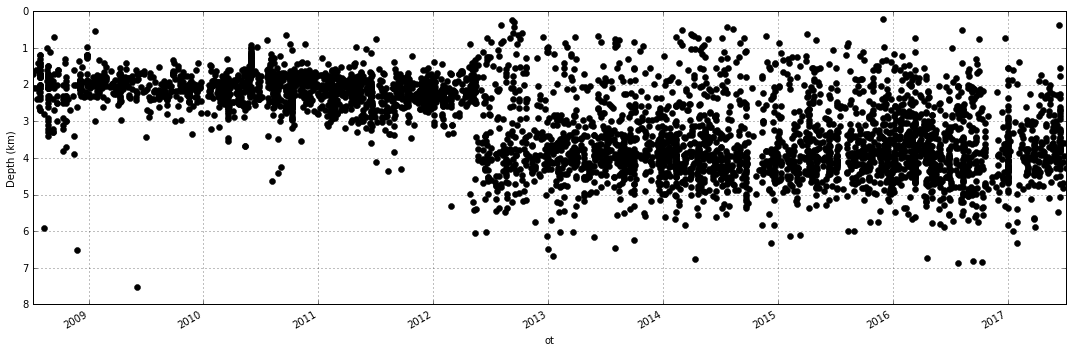

In [31]:
#depth vs time
dp = dep_all.plot(y='z', color='black', marker='o', linewidth=0.3, linestyle='None', legend=False, figsize=(15,5))
dp.xaxis.grid()
dp.yaxis.grid()

dp.set_ylim([0,8])
dp.set_ylabel('Depth (km)')

plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig('mercury_all_time-depth.png', dpi=200)

**Number of events within 5 km of Rotokawa reference point**

In [15]:
#reference point (just south of Rotokawa power station)
latref = -38.615574
lonref = 176.193669

In [16]:
hypdd['dist'] = haversine_np(hypdd['longitude'],hypdd['latitude'],lonref,latref)

In [17]:
hypdd['dist'][(hypdd['dist']<=5)&(hypdd.index>=thisrpt)&(hypdd.index<=end)].describe()

count    573.000000
mean       1.342067
std        0.784273
min        0.051122
25%        0.803419
50%        1.230396
75%        1.658321
max        4.976466
Name: dist, dtype: float64

**Number of events within 5 km of Rotokawa reference point for the previous reporting period**

In [18]:
hypdd['dist'][(hypdd['dist']<=5)&(hypdd.index>=lastrpt)&(hypdd.index<=lastend)].describe()

count    822.000000
mean       1.402708
std        0.830758
min        0.113165
25%        0.842197
50%        1.203122
75%        1.715643
max        4.794771
Name: dist, dtype: float64

**Filter for plotting area**

In [19]:
#filter hypocentres to plot area, to just get rotokawa
hypdd = hypdd[(hypdd['longitude']>lonmin)&(hypdd['longitude']<lonmax)&(hypdd['latitude']>latmin)&(hypdd['latitude']<latmax)]

In [20]:
len(hypdd)

2962

In [21]:
#filter hypocentres for reporting period, to get rotokawa for just reporting period
hyprpt = hypdd[(hypdd.index>thisrpt)&(hypdd.index<end)]

In [22]:
hyprpt.head()

,latitude,longitude,z,ml,dist
ot,,,,,
2016-07-01 09:09:00,-38.619718,176.203597,3.265,1.0,0.977296
2016-07-02 07:20:47,-38.601017,176.210124,5.139,0.9,2.158362
2016-07-03 00:34:52,-38.609204,176.190820,4.566,0.6,0.749849
2016-07-03 15:25:32,-38.616378,176.212109,4.706,1.1,1.603585
2016-07-05 20:13:27,-38.615499,176.198031,4.822,1.4,0.378834


In [23]:
hyprpt['ml'].describe()

count    526.000000
mean       1.179278
std        0.466811
min        0.500000
25%        0.900000
50%        1.100000
75%        1.400000
max        4.100000
Name: ml, dtype: float64

In [24]:
hyprpt[hyprpt['ml']>=4]

,latitude,longitude,z,ml,dist
ot,,,,,
2017-01-02 09:12:53,-38.612337,176.207926,4.184,4.1,1.289133
2017-06-15 01:21:44,-38.611804,176.199561,4.196,4.0,0.661248


**Plot hypocentres on Open Street Map basemap**

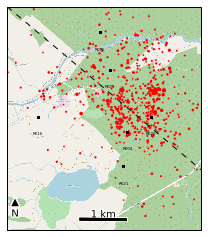

In [25]:
#imagery
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([lonmin, lonmax, latmin, latmax])
ax.add_image(imagery, 15)
#ax.gridlines()

#hypocentres, symbol size=magnitude squared, as scatter symbol size is symbol area, square gives 'pleasing' image
plt.scatter(hyprpt['longitude'], hyprpt['latitude'], color='red', marker='o', s=hyprpt['ml']**2, transform=ccrs.Geodetic())

#plot wells
names = ['lon', 'lat', 'name']
wells = pd.read_csv('wells.dat', sep='\s+', names=names)
plt.scatter(wells['lon'], wells['lat'], color='black', marker='s', s=5, transform=ccrs.Geodetic())
#transform coordinate system so can plot text below symbol
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-15)
#plot text labels
for index, row in wells.iterrows():
    plt.text(row['lon'], row['lat'], row['name'], verticalalignment='top', horizontalalignment='center', transform=text_transform, fontsize=4)
#section line
plt.plot([176.17,176.22], [-38.595,-38.62789], color='black', linestyle='--', marker='None', transform=ccrs.Geodetic())

scale_bar(ax, ccrs.Mercator(), 1)

plt.savefig('mercury_thisreport_map.png', dpi=400)

**NZ Active Faults Database**

In [26]:
#use existing GMT format file with '>' indicating a line break
names=['longitude', 'latitude']
faults = pd.read_csv('/home/sherburn/mapdata/nzafd_250k.psxy', sep='\s+', na_values='>', names=names)

In [27]:
faults.head()

,longitude,latitude
0,170.100705,-46.016087
1,170.101990,-46.014049
2,170.103576,-46.012303
3,170.104604,-46.011326
4,170.106938,-46.010170


**Wells**

In [28]:
#wells for plotting
names = ['lon', 'lat', 'name']
wells = pd.read_csv('wells.dat', sep='\s+', names=names)

**Cross-section**

In [29]:
#export data
hyprpt.to_csv('section.csv', header=False)

#run external program, temporary solution
!section.csh

In [30]:
#read output of external program
names=['p', 'q', 'z', 'ml']
seceqs = pd.read_csv('section.dat', sep='\s+', names=names)
#pq nomerclature is that used by GMT project command http://gmt.soest.hawaii.edu/doc/5.4.2/project.html

In [31]:
seceqs.head()

,p,q,z,ml
0,1.337744,-0.418800,3.265,1.0
1,-0.264133,-0.236740,4.566,0.6
2,1.665629,0.341009,4.706,1.1
3,0.665756,-0.370216,4.822,1.4
4,0.712633,-0.349173,3.669,1.2


In [32]:
#read well data (pre-projected)
names=['p', 'q', 'z']
well04 = pd.read_csv('well_section_04.dat', sep='\s+', names=names)
well05 = pd.read_csv('well_section_05.dat', sep='\s+', names=names)
well06 = pd.read_csv('well_section_06.dat', sep='\s+', names=names)
well20 = pd.read_csv('well_section_20.dat', sep='\s+', names=names)

In [33]:
well04.head()

,p,q,z
0,1.162742,-0.511771,-0.33000
1,1.162742,-0.511771,1.00021
2,1.162742,-0.511771,2.11021


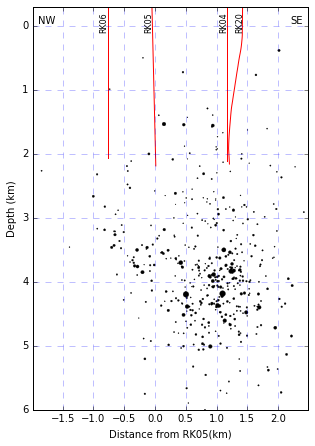

In [34]:
#size scaled to give 1:1 ratio
fig = plt.figure(figsize=(4.48,6.3))

#earthquakes
plt.scatter(x=seceqs['p'], y=seceqs['z'], s=2*seceqs['ml']**2, color='black', marker='o', linewidth=0.3)
# wells
plt.plot(well04['p'], well04['z'], color='red')
plt.plot(well05['p'], well05['z'], color='red')
plt.plot(well06['p'], well06['z'], color='red')
plt.plot(well20['p'], well20['z'], color='red')
#well labels
plt.text(1.05, 0.1, 'RK04', verticalalignment='bottom', horizontalalignment='left', rotation='vertical', fontsize=8)
plt.text(-0.18, 0.1, 'RK05', verticalalignment='bottom', horizontalalignment='left', rotation='vertical', fontsize=8)
plt.text(-0.9, 0.1, 'RK06', verticalalignment='bottom', horizontalalignment='left', rotation='vertical', fontsize=8)
plt.text(1.3, 0.1, 'RK20', verticalalignment='bottom', horizontalalignment='left', rotation='vertical', fontsize=8)
#section orientations
plt.text(-1.9, -0, 'NW', verticalalignment='bottom', horizontalalignment='left', fontsize=10)
plt.text(2.4, -0, 'SE', verticalalignment='bottom', horizontalalignment='right', fontsize=10)

plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.xlim([-1.99,2.49])
plt.ylim([-0.3,6])
plt.ylabel('Depth (km)')
plt.xlabel('Distance from RK05(km)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('mercury_thisreport_section.png', dpi=200)

**Magnitude-time - Reporting period only**

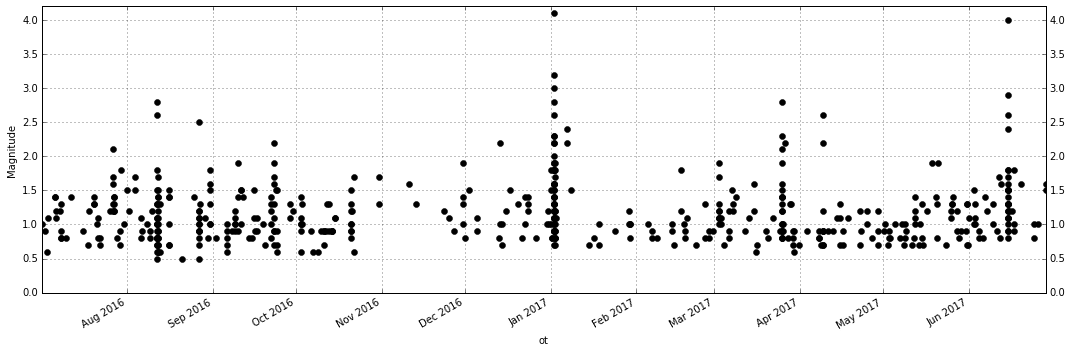

In [35]:
#magnitude vs time
ax = hyprpt.plot(y='ml', color='black', marker='o', linewidth=0.3, linestyle='None', legend=False, figsize=(15,5))
ax.xaxis.grid()
ax.yaxis.grid()

ax.set_ylim([0,4.2])
ax.set_ylabel('Magnitude')
ax.tick_params(labelright = True)

plt.tight_layout()
plt.savefig('mercury_thisreport_time-series.png', dpi=200)

In [69]:
hyprpt.to_csv('time-magnitude.csv', columns=['ml'])

**Magnitude-time and cumulative number - Complete period since 2008 & location within 5 km of reference point**

In [36]:
#get hypodd and hyprot again, so am dealing with orginal data
hypdd = pd.read_csv('rotnga_hypodd_all.csv', usecols=[3,4,5,6,7,8], parse_dates={"ot" : ['YYYY-MM-DD','hh:mm:sec']}, index_col='ot')
names=['nzmg_e', 'nzmg_n', 'latitude', 'longitude', 'z', 'ml', 'date', 'time']
hyprot = pd.read_csv('rotokawa_2008-2012-05-13.dat', usecols=[2,3,4,5,6,7], names=names, sep='\s+', parse_dates={"ot" : ['date','time']}, index_col='ot')
#append to get complete time-series
hypall = hyprot.append(hypdd)

In [37]:
#calculate distance from reference point
hypall['dist'] = haversine_np(hypall['longitude'],hypall['latitude'],lonref,latref)
len(hypall)

6434

In [38]:
#distance within 5 km
hypall = hypall[hypall['dist']<=5]

In [39]:
len(hypall)

5135

In [40]:
#eqs m>=0.8, magnitude of completeness in published study (2008-2012)
hypcmp = hypall[hypall['ml']>=0.8]
#make a column containing event number (should be a better way of doing this)
hypcmp.reset_index(inplace=True)
hypcmp['evnum'] = hypcmp.index+1
hypcmp.set_index('ot', inplace=True, drop=True)

In [41]:
hypcmp.head()

,latitude,longitude,z,ml,dist,evnum
ot,,,,,,
2008-07-14 08:58:25,-38.607279,176.191781,2.1,1.0,0.936248,1
2008-07-16 15:02:57,-38.614811,176.181852,1.6,1.0,1.029546,2
2008-07-22 14:25:12,-38.614734,176.183626,1.4,0.8,0.876998,3
2008-07-26 10:47:07,-38.614693,176.192578,2.6,1.3,0.136229,4
2008-07-28 05:32:18,-38.614217,176.188037,2.2,1.1,0.511741,5


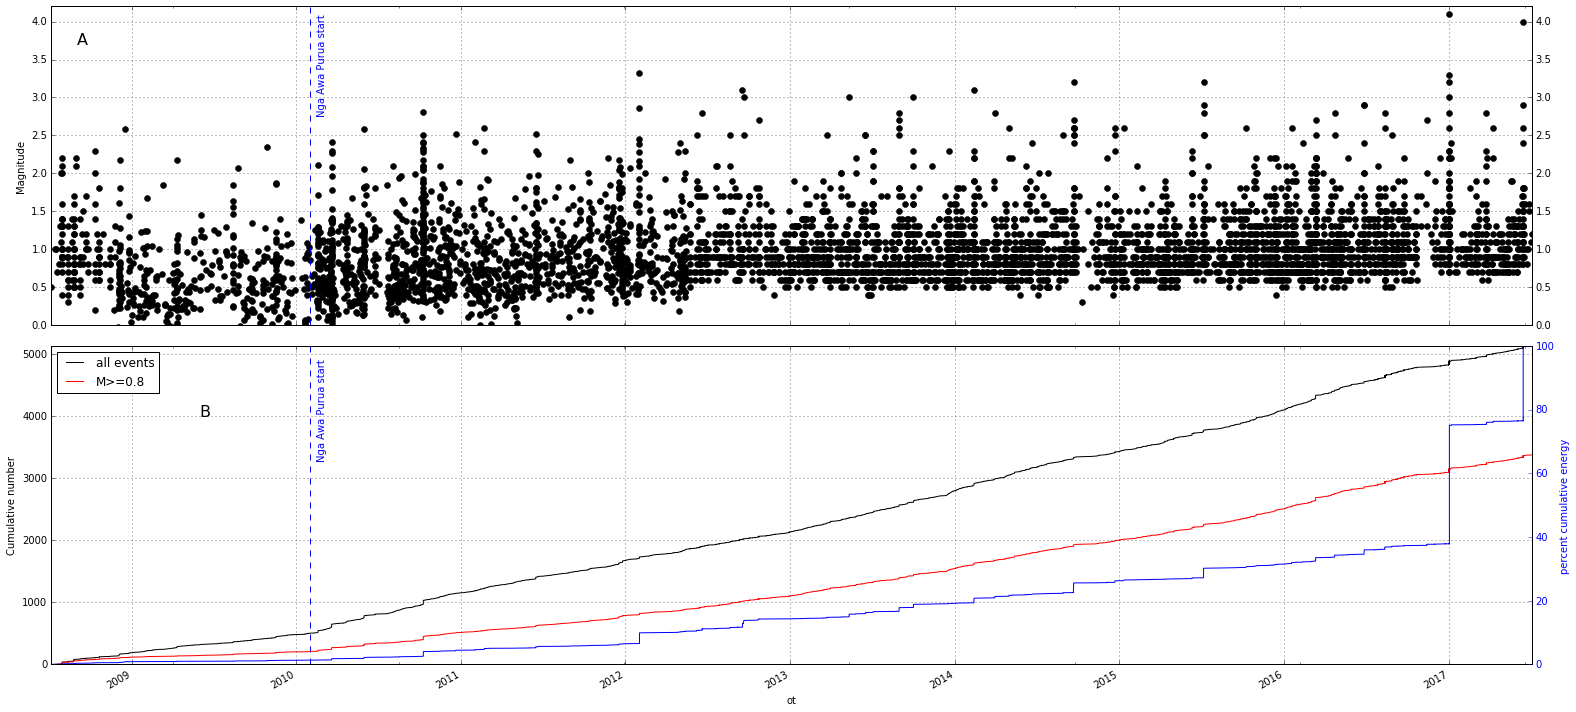

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(22,10))

#distance vs time
hypall.plot(y='ml', color='black', marker='o', linewidth=0.3, linestyle='None', legend=False, ax=ax1)

#plot labels
ax1.text('2008-09-01', 3.7, 'A', size=16)
ax1.axvline(x='2010-02-01', color='blue', linestyle='--')
ax1.text('2010-02-15', 4.0, 'Nga Awa Purua start', rotation='vertical', color='blue')

ax1.xaxis.grid()
ax1.yaxis.grid()
ax1.set_ylim([0,4.2])
ax1.set_ylabel('Magnitude')
ax1.tick_params(labelright = True)

#cumulative number vs time
#make a column containing event number (should be a better way of doing this)
hypall.reset_index(inplace=True)
hypall['evnum'] = hypall.index+1
nmax = hypall['evnum'].iloc[-1]
hypall.set_index('ot', inplace=True, drop=True)

#all eqs
hypall.plot(y='evnum', color='black',ax=ax2, label='all events')
ax2.set_ylim([0,nmax])

#plot labels
ax2.text('2009-06-01', 4000, 'B', size=16)
ax2.axvline(x='2010-02-01', color='blue', linestyle='--')
ax2.text('2010-02-15', 4800, 'Nga Awa Purua start', rotation='vertical', color='blue')

#m>=0.8
hypcmp.plot(y='evnum', color='red',ax=ax2, label='M>=0.8')
ax2.xaxis.grid()
ax2.yaxis.grid()
ax2.set_ylabel('Cumulative number')

#cumulative energy
hypall['energy'] = pow(10,(1.44 * hypall['ml'] + 5.24))
hypall['cumeng'] = hypall['energy'].cumsum()
hypall['cumeng'] = 100 * hypall['cumeng'] / hypall['cumeng'].max()
ax3= ax2.twinx()
ax3.plot(hypall['cumeng'], color='blue', marker='None')
ax3.tick_params(axis='y', colors='blue')
ax3.set_ylabel('percent cumulative energy', color = 'blue')

plt.tight_layout()
plt.savefig('mercury_long-term_time-series.png', dpi=200)

**Plot station map**

**Seismographs**

In [43]:
#rotokawa
names = ['lon', 'lat', 'name', 'height']
seis = pd.read_csv('seismograph_sites.dat', sep='\s+', names=names)

#ngatamariki
names = ['name', 'lat', 'lon']
seisng = pd.read_csv('seismograph_sites_ngatamariki.csv', names=names)

In [44]:
seisng.head()

,name,lat,lon
0,NS01,-38.508200,176.177000
1,NS03,-38.523259,176.209102
2,NS04,-38.542487,176.225718
3,NS07,-38.560793,176.227019
4,NS11,-38.565900,176.190300


**Station map plot area**

In [45]:
slonmin = 176.15
slonmax = 176.23
slatmin = -38.66
slatmax = -38.58

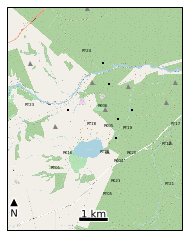

In [46]:
#imagery
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([slonmin, slonmax, slatmin, slatmax])
ax.add_image(imagery, 15)
#ax.add_image(imagery, 10)
#ax.gridlines()

#seismographs rotokawa
plt.plot(seis['lon'], seis['lat'], color='gray', markeredgewidth=0.0, linestyle='None', marker='^', markersize=5, transform=ccrs.Geodetic())
#seismographs ngatamariki
plt.plot(seisng['lon'], seisng['lat'], color='gray', markeredgewidth=0.0, linestyle='None', marker='^', markersize=5, transform=ccrs.Geodetic())
#transform coordinate system so can plot text below symbol
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-40)
#plot text labels
for index, row in seis.iterrows():
    plt.text(row['lon'], row['lat'], row['name'], verticalalignment='top', horizontalalignment='center', transform=text_transform, fontsize=4)

#wells
plt.plot(wells['lon'], wells['lat'], color='black', markeredgewidth=0.0, linestyle='None', marker='s', markersize=2, transform=ccrs.Geodetic())
#plot text labels
for index, row in wells.iterrows():
    plt.text(row['lon'], row['lat'], row['name'], verticalalignment='top', horizontalalignment='center', transform=text_transform, fontsize=4)

scale_bar(ax, ccrs.Mercator(), 1)
 
plt.savefig('mercury_station_map.png', dpi=400)

**Plot wide area station map, showing Ngatamariki and GeoNet**

**GeoNet Seismographs**

In [47]:
names = ['lon', 'lat', 'name']
seisgn = pd.read_csv('geonet_sites.dat', sep='\s+', names=names)

In [48]:
seisgn.head()

,lon,lat,name
0,176.12006,-38.62769,ARAZ
1,176.34282,-38.56381,ALRZ
2,176.16240,-38.51960,WPRZ
3,176.16980,-38.66840,THQ2


**Station map plot area**

In [49]:
wlonmin = 175.95
wlonmax = 176.43
wlatmin = -38.73
wlatmax = -38.45

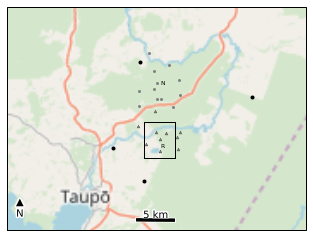

In [50]:
#imagery
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
ax.set_extent([wlonmin, wlonmax, wlatmin, wlatmax])
#ax.add_image(imagery, 15)
ax.add_image(imagery, 9)
#ax.gridlines()

#extents of detailed plot area
boxlon = [lonmin, lonmin, lonmax, lonmax, lonmin]
boxlat = [latmin, latmax, latmax, latmin, latmin]
plt.plot(boxlon, boxlat, color='black', linestyle='-', marker='None', transform=ccrs.Geodetic())

#seismographs rotokawa
plt.plot(seis['lon'], seis['lat'], color='gray', markeredgewidth=0.2, linestyle='None', marker='^', markersize=3, transform=ccrs.Geodetic())
#seismographs ngatamariki
plt.plot(seisng['lon'], seisng['lat'], color='gray', markeredgewidth=0.0, linestyle='None', marker='o', markersize=3, transform=ccrs.Geodetic())
#seismographs geonet
plt.plot(seisgn['lon'], seisgn['lat'], color='black', markeredgewidth=0.0, linestyle='None', marker='o', markersize=4, transform=ccrs.Geodetic())

#transform coordinate system so can plot text below symbol
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=0, x=0)
plt.text(176.200, -38.546, 'N', verticalalignment='center', horizontalalignment='center', transform=text_transform, fontsize=6)
plt.text(176.200, -38.625, 'R', verticalalignment='center', horizontalalignment='center', transform=text_transform, fontsize=6)

scale_bar(ax, ccrs.Mercator(), 5)
 
plt.savefig('mercury_wide-station_map.png', dpi=400)

## GeoNet seismicity

In [51]:
#box for search area
bbox = '176.0,-38.8,176.5,-38.3'
maxdep = '20'

url = 'http://quakesearch.geonet.org.nz/csv?bbox='+bbox+'&maxdepth='+maxdep+'&startdate='+start+'&enddate='+end

In [52]:
eqs = pd.read_csv(url, parse_dates=['origintime'], index_col='origintime', usecols=[2,4,5,6,7])

In [53]:
eqs.head()

,longitude,latitude,magnitude,depth
origintime,,,,
2017-06-30 18:34:32.410,176.141312,-38.629829,1.581365,6.881836
2017-06-30 12:23:11.101,176.094093,-38.618720,1.468808,5.117188
2017-06-30 01:36:42.387,176.367827,-38.301258,1.389622,5.117188
2017-06-28 19:00:56.295,176.212387,-38.621857,1.385814,4.868961
2017-06-28 14:18:20.887,176.132019,-38.488689,1.161033,3.049545


In [54]:
eqs['dist'] = haversine_np(eqs['longitude'],eqs[' latitude'],lonref,latref)

In [55]:
eqs10 = eqs[eqs['dist']<10]

In [56]:
eqs10['dist'].describe()

count    684.000000
mean       4.198866
std        2.946608
min        0.192692
25%        1.935373
50%        2.791396
75%        6.592161
max        9.993968
Name: dist, dtype: float64

In [57]:
eqs10.head()

,longitude,latitude,magnitude,depth,dist
origintime,,,,,
2017-06-30 18:34:32.410,176.141312,-38.629829,1.581365,6.881836,4.813746
2017-06-30 12:23:11.101,176.094093,-38.618720,1.468808,5.117188,8.652846
2017-06-28 19:00:56.295,176.212387,-38.621857,1.385814,4.868961,1.768796
2017-06-17 09:53:58.921,176.197934,-38.607947,1.466691,5.058594,0.924928
2017-06-16 17:44:00.570,176.089430,-38.645874,1.361598,5.058594,9.655024


In [58]:
eqs10[eqs10[' magnitude']>=3]

,longitude,latitude,magnitude,depth,dist
origintime,,,,,
2017-06-15 01:21:44.208,176.204518,-38.614817,3.761756,7.871094,0.945750
2017-01-02 09:12:54.748,176.207809,-38.619743,3.968849,4.371635,1.312257
2017-01-02 09:00:46.686,176.217117,-38.617100,3.137818,3.500734,2.042988
2014-09-21 15:09:13.663,176.218954,-38.624011,3.022326,7.988281,2.387187
2014-09-21 15:06:23.991,176.222352,-38.620157,3.045443,8.164062,2.541959
2012-10-23 08:49:41.962,176.214142,-38.620946,3.034572,6.230469,1.875128
2012-02-01 11:04:43.644,176.245936,-38.620464,3.608296,5.197500,4.570469


**Number of GeoNet earthquakes within 5 & 10 km during the report period**

In [59]:
eqs[' magnitude'][(eqs['dist']<=10)&(eqs.index>=thisrpt)&(eqs.index<=end)].describe()

count    86.000000
mean      1.895004
std       0.512919
min       1.159287
25%       1.556470
50%       1.784697
75%       2.079155
max       3.968849
Name:  magnitude, dtype: float64

In [60]:
eqs[' magnitude'][(eqs['dist']<=5)&(eqs.index>=thisrpt)&(eqs.index<=end)].describe()

count    56.000000
mean      2.025678
std       0.564310
min       1.280838
25%       1.608211
50%       1.888125
75%       2.309584
max       3.968849
Name:  magnitude, dtype: float64

**And for the previous report period**

In [61]:
eqs[' magnitude'][(eqs['dist']<=10)&(eqs.index>=lastrpt)&(eqs.index<=lastend)].describe()

count    122.000000
mean       1.834706
std        0.372544
min        1.042333
25%        1.604507
50%        1.800371
75%        2.056949
max        2.962477
Name:  magnitude, dtype: float64

In [62]:
eqs[' magnitude'][(eqs['dist']<=5)&(eqs.index>=lastrpt)&(eqs.index<=lastend)].describe()

count    81.000000
mean      1.836691
std       0.367222
min       1.164773
25%       1.589678
50%       1.776052
75%       2.065370
max       2.876509
Name:  magnitude, dtype: float64

**And the one before that**

In [63]:
eqs[' magnitude'][(eqs['dist']<=10)&(eqs.index>=last2rpt)&(eqs.index<=last2end)].describe()

count    77.000000
mean      1.871257
std       0.404525
min       1.072151
25%       1.619645
50%       1.824544
75%       2.129675
max       3.045443
Name:  magnitude, dtype: float64

In [64]:
eqs[' magnitude'][(eqs['dist']<=5)&(eqs.index>=last2rpt)&(eqs.index<=last2end)].describe()

count    45.000000
mean      1.903467
std       0.456678
min       1.167379
25%       1.613401
50%       1.818039
75%       2.230276
max       3.045443
Name:  magnitude, dtype: float64

**Biggest events**

In [65]:
eqs[eqs[' magnitude']>3.5]

,longitude,latitude,magnitude,depth,dist
origintime,,,,,
2017-06-15 01:21:44.208,176.204518,-38.614817,3.761756,7.871094,0.945750
2017-01-02 09:12:54.748,176.207809,-38.619743,3.968849,4.371635,1.312257
2015-07-03 11:58:42.188,176.056833,-38.621743,3.501399,8.164062,11.900433
2012-02-01 11:04:43.644,176.245936,-38.620464,3.608296,5.197500,4.570469


**Plots vs Time**

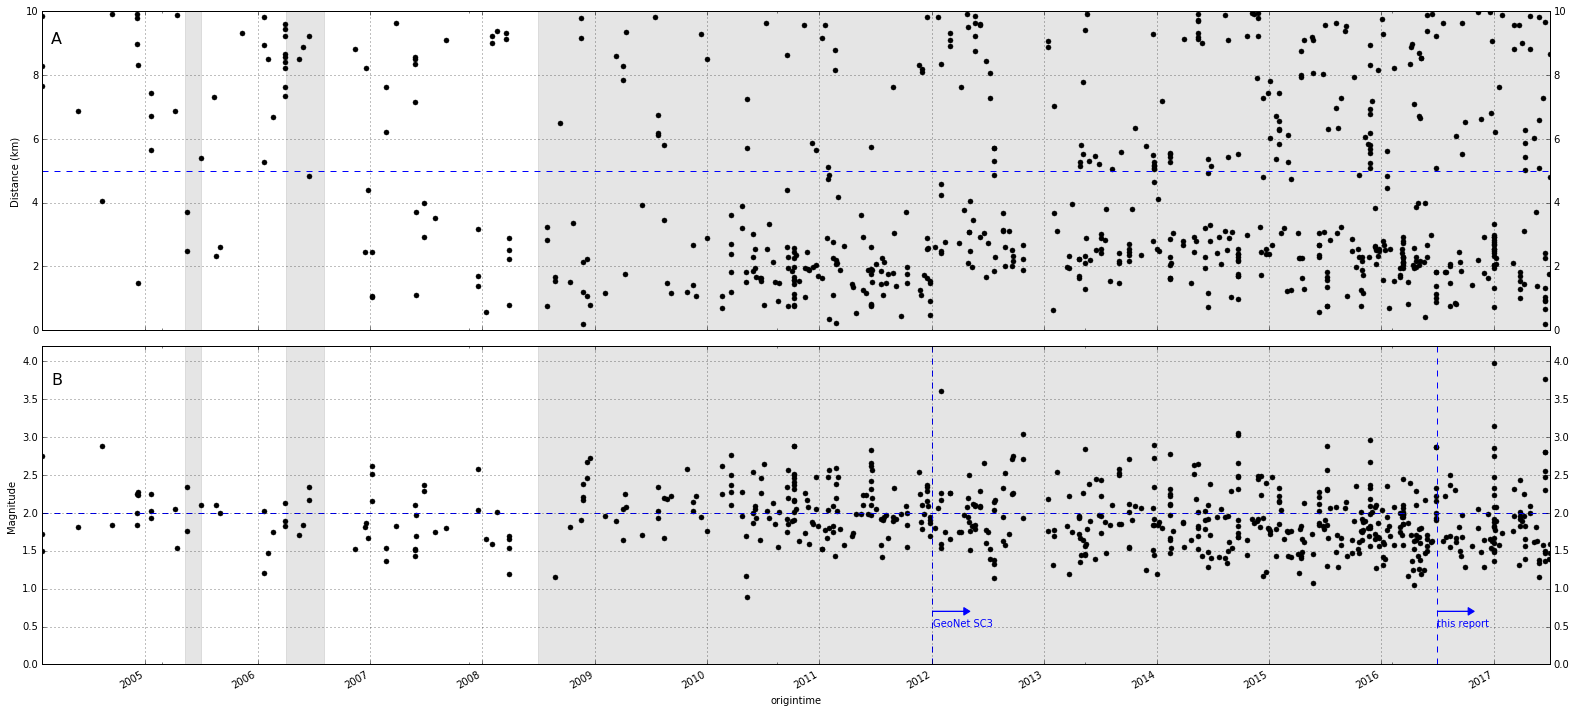

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(22,10))

#distance vs time
eqs10.plot(y='dist', marker='o', markersize=5, linestyle='None', color='black', legend=False, ax=ax1)

#plot label A
ax1.text('2004-03-01', 9, 'A', size=16)

#yearly ticks and grid
majorTick = mpl.dates.YearLocator(1)
majorFormat = mpl.dates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(majorTick)
ax1.xaxis.set_major_formatter(majorFormat)
ax1.xaxis.grid()
ax1.yaxis.grid()

ax1.set_ylabel('Distance (km)')

ax1.tick_params(labelright = True)

#dashed line at dist=5 km
ax1.axhline(y=5, color='blue', linestyle='--')

#greyed areas
ax1.axvspan('2005-05-09', '2005-06-30', alpha=0.2, color='gray', label='not used')
ax1.axvspan('2006-04-04', '2006-08-06', alpha=0.2, color='gray')
ax1.axvspan('2008-07-01', end, alpha=0.2, color='gray')

#magnitude vs time
eqs10.plot(y=' magnitude', marker='o', markersize=5, linestyle='None', color='black', legend=False, ax=ax2)

#plot label 8
ax2.text('2004-03-01', 3.7, 'B', size=16)

#yearly ticks and grid
ax2.xaxis.set_major_locator(majorTick)
ax2.xaxis.set_major_formatter(majorFormat)
ax2.xaxis.grid()
ax2.yaxis.grid()

ax2.set_ylim([0,4.2])
ax2.set_ylabel('Magnitude')
ax2.tick_params(labelright = True)

#dashed line at magnitude=2, about felt threshold
ax2.axhline(y=2, color='blue', linestyle='--')

#greyed areas
ax2.axvspan('2005-05-09', '2005-06-30', alpha=0.2, color='gray', label='not used')
ax2.axvspan('2006-04-04', '2006-08-06', alpha=0.2, color='gray')
ax2.axvspan('2008-07-01', end, alpha=0.2, color='gray')

#indicate start of SC3
ax2.axvline(x='2012-01-01', color='blue', linestyle='--')
ax2.text('2012-01-05', 0.5, 'GeoNet SC3', color='blue')
ax2.arrow('2012-01-05', 0.7, 100, 0, head_width=0.1, head_length=20, fc='blue', ec='blue')

#indicate this report
ax2.axvline(x=thisrpt, color='blue', linestyle='--')
ax2.text(thisrpt, 0.5, 'this report', color='blue')
ax2.arrow(thisrpt, 0.7, 100, 0, head_width=0.1, head_length=20, fc='blue', ec='blue')

plt.tight_layout()
plt.savefig('geonet_long-term_time-series.png', dpi=200)